# 🧪 <span style="color:#6f5b85;">  TP: Simulating and modeling material properties at the atomic scale <span>

Welcome to this hands-on session, where we will explore atomic-scale physical phenomena such as *diffusion* and *plasticity* using **atomistic simulations**. 

We will work with the code **LAMMPS (https://docs.lammps.org/Manual.html)**, a widely used molecular dynamics engine in the materials science community, through the **Python interface provided by ASE** (Atomic Simulation Environment). ASE offers a flexible and user-friendly framework for building, running, and analyzing atomistic simulations in a programmable way.


🔧 **Tools we will use**:
- **LAMMPS**: classical molecular dynamics simulator
- **Python + ASE**: scripting and analysis interface

---

## 🗺️ <span style="color:#957bb1;"> Objectives <span>

In this session, we will investigate two fundamental phenomena in materials science, combining **molecular dynamics (MD)** with a simplified **kinetic Monte Carlo (KMC)** approach:

1. 🔬 **Point defect diffusion in a metal**  
   → From atomistic dynamics to kinetic modeling (simple KMC)

2. 🛠️ **Nanoindentation**  
   → Simulating the mechanical response of a material under local deformation

---

🎯 By the end of this lab, you will be able to:
- Run and control LAMMPS simulations via Python/ASE
- Analyze atomic-scale mechanisms
- Bridge the gap between atomistic MD and mesoscopic KMC modeling


## <span style="color:#957bb1;"> About LAMMPS code <span>

**LAMMPS** (Large-scale Atomic/Molecular Massively Parallel Simulator) is a powerful and widely-used molecular dynamics simulation package developed by Sandia National Laboratories.  
You can install LAMMPS from its official source code repository on GitHub:  

```bash
git clone https://github.com/lammps/lammps.git
cd lammps
mkdir build
cd build
cmake ../cmake
make -j4
sudo make install
```

### <span style="color:#7140ff">However, in this TP, we do MD simulation indirectly via the Python interface provided by **ASE** (Atomic Simulation Environment). ASE makes it easier to set up simulations, and is good for demo.<span>



# <span style="color:#6f5b85;"> Example: Running a simple MD calculation via ASE <span>


## 1) Build the system

In the solid state, most metals adopt a **crystalline structure**, meaning that their atoms are arranged in a periodic and highly ordered lattice that extends in all three spatial dimensions. This long-range order results from the minimization of the system's free energy and reflects the balance between atomic bonding forces and packing efficiency.

The fundamental building block of a crystal is the **unit cell** — the smallest repeatable volume that, when translated through space, reconstructs the entire lattice. Its geometry and atomic content define the material’s symmetry and physical properties.

Common metallic crystal structures include:

- **Face-Centered Cubic (FCC)**: atoms at each cube corner and at the center of each face (e.g., Cu, Al, Ni, Au).
- **Body-Centered Cubic (BCC)**: atoms at each corner and one atom in the center of the cube (e.g., Fe, Mo, Cr).
- **Hexagonal Close-Packed (HCP)**: atoms arranged in a hexagonal pattern with dense atomic layers (e.g., Mg, Ti, Zn).

For this tutorial, we will focus on **nickel**, a metal with an FCC crystal structure.

In [10]:
from ase.build import bulk

# 'Al' is the atom type, 'a' the lattice parameter  
unit_cell = bulk('Ni', crystalstructure='fcc', a=3.6, cubic=True)


In [12]:
# it is possible to visalize the cell using nglview

import nglview as nv
# Visualisation interactive
view = nv.show_ase(unit_cell)
view.add_unitcell()
view.background = 'white'
view.camera = 'orthographic'
view

NGLWidget()

The unit cell can be replicated along each spatial direction to build a larger **supercell**, which is often useful to better capture the material's periodicity or to simulate extended systems.

For example, to replicate the unit cell three times in each direction, you can use:

```python
super_cell = unit_cell.repeat((3, 3, 3))


In [13]:
super_cell = unit_cell.repeat((3, 3, 3))
view = nv.show_ase(super_cell)
view.add_unitcell()
view.background = 'white'
view.camera = 'orthographic'
view


NGLWidget()

### <span style="color:#60a976;"> To do: Try different crystal structures and visualize it. <span>

## 2) Choice of the interatomic potential 

In molecular dynamics simulations, the choice of **interatomic potential** is critical for accurately capturing the physical behavior of materials. For metals, several classes of **empirical potentials** have been developed to model metallic bonding and its many-body nature.

The most commonly used potentials for metals include:

- **EAM (Embedded Atom Method)**  
  The total energy is given by:  
  $$
  E = \sum_i F_i(\rho_i) + \frac{1}{2} \sum_{i \neq j} \phi_{ij}(r_{ij})
  $$
  where $F_i$ is the embedding function, $\rho_i$ is the local electron density, and $\phi_{ij}$ is a pair interaction.

- **MEAM (Modified Embedded Atom Method)**  
  Extends EAM to include angular dependence for more complex crystal structures.

- **Finnis–Sinclair (FS)**  
  A variant of EAM with a simpler form for the embedding function.

- **Tersoff or Stillinger-Weber**  
  Mainly used for covalent systems, but occasionally adapted for metal-semiconductor systems.

These potentials are not universal — they are fitted for specific elements or alloys and must be chosen carefully based on the system and properties of interest.

🗂️ **Where to find LAMMPS-compatible potentials**:
- [LAMMPS Potential Directory](https://www.lammps.org/patches/poems/potentials.html)
- [NIST Interatomic Potentials Repository](https://www.ctcms.nist.gov/potentials/)



For this tutorial, we will use the **Angelo et al. (1995)** EAM potential, available from the [NIST Interatomic Potentials Repository](https://www.ctcms.nist.gov/potentials/Download/1995--Angelo-J-E-Moody-N-R-Baskes-M-I--Ni-Al-H/1/NiAlH_jea.eam.alloy), which is designed for the **Ni–Al–H** system.

This potential is particularly suitable for modeling **Ni–Al alloys**, and is capable of capturing essential features of their **thermodynamic and mechanical behavior**, including phase stability and defect energetics, thanks to its formulation within the **Embedded Atom Method (EAM)** framework that accounts for the many-body nature of metallic bonding.



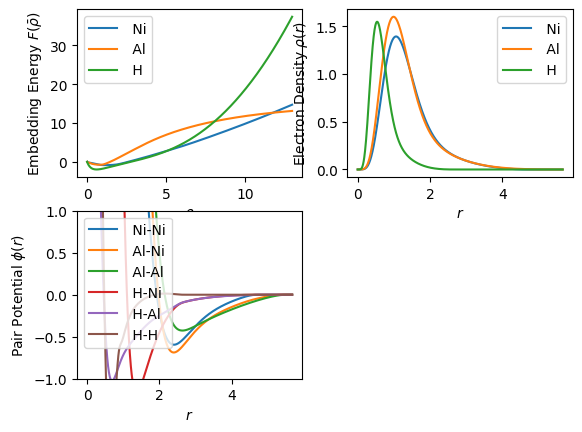

In [20]:
from ase.calculators.eam import EAM

angelo = EAM(potential = 'Potential/NiAlH_jea.eam.alloy')

# Visualize the different component of the EAM potential 
angelo.plot()

**ASE** not only allows us to easily construct atomic systems but also assign interatomic potentials, and run simulations.

ASE includes algorithms for *energy minimization*, *molecular dynamics* (MD), and a wide range of analysis utilities. This significantly reduces the complexity of preparing input files and post-processing results.

**We will use ASE as interface for this TP to perform our simulations.**

In [21]:
from ase.calculators.lammpsrun import LAMMPS
import os
# Set the path to the LAMMPS executable
os.environ["ASE_LAMMPSRUN_COMMAND"] = "lammps_ase/build/lmp"
os.environ["LD_LIBRARY_PATH"] = "lammps_ase/build:" + os.environ.get("LD_LIBRARY_PATH", "")

# assign the potential to the system build in LAMMPS
parameters = {'pair_style': 'eam/alloy', 'pair_coeff': ['* * Potential/NiAlH_jea.eam.alloy Ni'] }
files = ['Potential/NiAlH_jea.eam.alloy']  
lammps = LAMMPS(files=files, **parameters)

# Attach calculator to atoms
super_cell.calc = lammps

# select algortihme
from ase.optimize import BFGS
opt = BFGS(super_cell)  
opt.run(fmax=0.0001) 

# get potential energy of the system
Energy = super_cell.get_potential_energy()

print('\n'+'*'*70)
print(f'Potential energy: {Energy} eV')
print('*'*70+'\n')



      Step     Time          Energy          fmax
BFGS:    0 10:01:01     -477.731621        0.000000

**********************************************************************
Potential energy: -477.7316209125584 eV
**********************************************************************



## 3) Get the optimized configuration

**Before running any meaningful simulation**, it is essential to **relax** the atomic structure to ensure it is in a state of minimal energy **under the chosen interatomic potential**. The initial geometry may not correspond exactly to the equilibrium configuration predicted by the potential, which can lead to non-physical results or unstable dynamics.

Relaxation involves adjusting atomic positions (and the cell) to find a local minimum of the potential energy surface, ensuring that forces on atoms are close to zero. This step is especially important when using empirical potentials, which may shift the equilibrium lattice parameters slightly compared to experimental data.

For instance the stress in our inital system with a lattice parameter selected of 4.15Å are not null :

In [22]:
super_cell.get_stress()


array([6.58265883e-02, 6.58265883e-02, 6.58265883e-02, 1.49826230e-17,
       4.12903464e-17, 9.51837226e-18])

One effective way to determine the equilibrium volume and lattice constant of a material under a given interatomic potential is to use an **Equation of State (EOS)**. This approach consists of computing the total energy of the system at different volumes (by isotropically scaling the unit cell).

By **finding the volume that minimizes the energy**, we can determine the optimal lattice parameter for the chosen potential. This ensures that the structure is well-relaxed and physically consistent with the behavior encoded in the empirical potential, **before proceeding to molecular dynamics or other simulations**.

### <span style="color:#60a976;"> To do: Repeat the calculations while varying the lattice parameter a, and observe how the potential energy and stress evolve.  <span>    

Fortunately, this process can be automated using ASE's built-in tools, which streamline the calculation of energy as a function of volume and allow easy fitting to an equation of state.

    Lattice       Volume      Energy
0      3.40  1061.208000 -472.844379
1      3.41  1070.599167 -474.143363
2      3.42  1080.045576 -475.313206
3      3.43  1089.547389 -476.357193
4      3.44  1099.104768 -477.278544
5      3.45  1108.717875 -478.080413
6      3.46  1118.386872 -478.765892
7      3.47  1128.111921 -479.338009
8      3.48  1137.893184 -479.799735
9      3.49  1147.730823 -480.153976
10     3.50  1157.625000 -480.403582
11     3.51  1167.575877 -480.551346
12     3.52  1177.583616 -480.600001
13     3.53  1187.648379 -480.552271
14     3.54  1197.770328 -480.411153
15     3.55  1207.949625 -480.177426
16     3.56  1218.186432 -479.856071
17     3.57  1228.480911 -479.448401
18     3.58  1238.833224 -478.956858
19     3.59  1249.243533 -478.383822
20     3.60  1259.712000 -477.731621 

**********************************************************************
Optimized lattice: 3.5200 Å
**********************************************************************


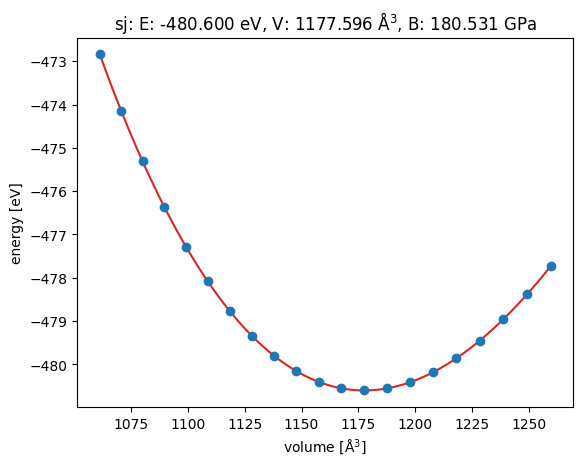

In [23]:
import numpy as np
import pandas as pd

Energy = []
Volume = []
alat =[]
for lattice in np.arange(3.4, 3.6, 0.01):
    unit_cell = bulk('Ni', crystalstructure='fcc', a=lattice, cubic=True)
    super_cell = unit_cell.repeat((3, 3, 3))
    super_cell.calc = lammps
    Energy.append(super_cell.get_potential_energy())
    Volume.append(super_cell.get_volume())
    alat.append(lattice)

data = pd.DataFrame()
data['Lattice'] = alat
data['Volume'] = Volume
data['Energy'] = Energy

print(data, '\n')

optimized_lattice = data.loc[data["Energy"].idxmin(), "Lattice"]

print('*'*70)
print(f"Optimized lattice: {optimized_lattice:.4f} Å")
print('*'*70)


from ase.eos import EquationOfState
eos = EquationOfState(Volume, Energy)
v0, e0, B = eos.fit()
eos.plot()

unit_cell = bulk('Ni', crystalstructure='fcc', a=optimized_lattice, cubic=True)
super_cell = unit_cell.repeat((3, 3, 3))
super_cell.calc = lammps


### ✅ <span style="color:#60a976;"> Well done! You've successfully obtained the relaxed crystal structure.  <span>
 
### 👉 <span style="color:#60a976;"> Now continue with the next tutorial: **Defects in Metals**, available in the notebook [`defects.ipynb`](./defects.ipynb). <span>
